# Linear Regression, KNN, Light Gradient Boosting Model Regressor (LGBMRegressor), Extreme Gradient Boosting Regressor (XGBRegressor), Random Forest  - <br /> by Jerome, 30 November 2021 #

---

In [1]:
## load modules
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from modeling.functions import modelling, log_to_mlflow, get_features 
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler


RSEED = 42


/Users/jeromesauer/neuefische/Capstone_WindPowerPredicting/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Read data, remove NaNs and get dummies for cardinal wind directions ###

In [2]:
## read data
data = pd.read_csv('../data/GEFCom2014Data/Wind/raw_data_incl_features.csv', parse_dates=['TIMESTAMP'])
data.dropna(inplace=True)
data = pd.get_dummies(data, columns = ['WD100CARD','WD10CARD'], drop_first=True)
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 175265 entries, 0 to 175433
Data columns (total 47 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ZONEID         175265 non-null  int64         
 1   TIMESTAMP      175265 non-null  datetime64[ns]
 2   TARGETVAR      175265 non-null  float64       
 3   U10            175265 non-null  float64       
 4   V10            175265 non-null  float64       
 5   U100           175265 non-null  float64       
 6   V100           175265 non-null  float64       
 7   HOUR           175265 non-null  int64         
 8   MONTH          175265 non-null  int64         
 9   WEEKDAY        175265 non-null  int64         
 10  IS_HOLIDAY     175265 non-null  int64         
 11  WS10           175265 non-null  float64       
 12  WS100          175265 non-null  float64       
 13  WD10           175265 non-null  float64       
 14  WD100          175265 non-null  float64       
 15  

,ZONEID,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,HOUR,MONTH,WEEKDAY,...,WD10CARD_NNW,WD10CARD_NW,WD10CARD_S,WD10CARD_SE,WD10CARD_SSE,WD10CARD_SSW,WD10CARD_SW,WD10CARD_W,WD10CARD_WNW,WD10CARD_WSW
0,1,2012-01-01 01:00:00,0.000000,2.124600,-2.681966,2.864280,-3.666076,1,1,6,...,0,1,0,0,0,0,0,0,0,0
1,1,2012-01-01 02:00:00,0.054879,2.521695,-1.796960,3.344859,-2.464761,2,1,6,...,0,1,0,0,0,0,0,0,0,0
2,1,2012-01-01 03:00:00,0.110234,2.672210,-0.822516,3.508448,-1.214093,3,1,6,...,0,0,0,0,0,0,0,0,1,0
3,1,2012-01-01 04:00:00,0.165116,2.457504,-0.143642,3.215233,-0.355546,4,1,6,...,0,0,0,0,0,0,0,1,0,0
4,1,2012-01-01 05:00:00,0.156940,2.245898,0.389576,2.957678,0.332701,5,1,6,...,0,0,0,0,0,0,0,1,0,0


### Train-test-split, get different combinations of features and run different models with them ###

In [3]:
## train-test-split
data_train, data_test = train_test_split(data, test_size=0.25, random_state=RSEED, stratify=data.ZONEID)

In [57]:
## get features and zones
feature_dict = get_features(data)
zones = np.unique(data.ZONEID)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [5]:
## run different models
models = ['LR', 'KNN', 'LGBM', 'RF', 'XGB']
results = {key : {} for key in feature_dict.keys()}

# loop over various combinations of features
for key in feature_dict.keys(): 

    # linear regression
    if 'LR' in models:
        results[key]['LR_train'], results[key]['LR_test'] = \
            modelling(data_train, data_test, feature_dict[key], LinearRegression())
        results[key]['LR_train'] = {k : np.round(value,4) for k,value in results[key]['LR_train'].items()}
        results[key]['LR_test'] = {k : np.round(value,4) for k,value in results[key]['LR_test'].items()}

    # KNN
    if 'KNN' in models:
        results[key]['KNN_train'], results[key]['KNN_test'] = \
            modelling(data_train, data_test, feature_dict[key], KNeighborsRegressor(n_neighbors=5, n_jobs=-1), \
                      scaler=MinMaxScaler())
        results[key]['KNN_train'] = {k : np.round(value,4) for k,value in results[key]['KNN_train'].items()}
        results[key]['KNN_test'] = {k : np.round(value,4) for k,value in results[key]['KNN_test'].items()}

    # LGBM
    if 'LGBM' in models:
        results[key]['LGBM_train'], results[key]['LGBM_test'] = \
            modelling(data_train, data_test, feature_dict[key], LGBMRegressor(random_state=RSEED))
        results[key]['LGBM_train'] = {k : np.round(value,4) for k,value in results[key]['LGBM_train'].items()}
        results[key]['LGBM_test'] = {k : np.round(value,4) for k,value in results[key]['LGBM_test'].items()}

    # RandomForest
    if 'RF' in models:
        regressor = RandomForestRegressor(max_depth=10, n_estimators=100, min_samples_leaf=6, n_jobs=-1, random_state=RSEED)
        results[key]['RF_train'], results[key]['RF_test'] = \
            modelling(data_train, data_test, feature_dict[key], regressor)
        results[key]['RF_train'] = {k : np.round(value,4) for k,value in results[key]['RF_train'].items()}
        results[key]['RF_test'] = {k : np.round(value,4) for k,value in results[key]['RF_test'].items()}

    # XGBoost
    if 'XGB' in models:
        results[key]['XGB_train'], results[key]['XGB_test'] = \
            modelling(data_train, data_test, feature_dict[key], XGBRegressor(random_state=RSEED))
        results[key]['XGB_train'] = {k : np.round(value,4) for k,value in results[key]['XGB_train'].items()}
        results[key]['XGB_test'] = {k : np.round(value,4) for k,value in results[key]['XGB_test'].items()}

train-RMSE/test-RMSE linear regression model for ZONE1: 0.181 0.183

train-RMSE/test-RMSE linear regression model for ZONE2: 0.154 0.149

train-RMSE/test-RMSE linear regression model for ZONE3: 0.152 0.154

train-RMSE/test-RMSE linear regression model for ZONE4: 0.177 0.179

train-RMSE/test-RMSE linear regression model for ZONE5: 0.18 0.183

train-RMSE/test-RMSE linear regression model for ZONE6: 0.188 0.185

train-RMSE/test-RMSE linear regression model for ZONE7: 0.138 0.139

train-RMSE/test-RMSE linear regression model for ZONE8: 0.17 0.17

train-RMSE/test-RMSE linear regression model for ZONE9: 0.165 0.164

train-RMSE/test-RMSE linear regression model for ZONE10: 0.203 0.205

train-RMSE/test-RMSE linear regression model for TOTAL: 0.172 0.172

Scaler: MinMaxScaler
Scaled X_train min/max: 0.0, 1.0
Scaled X_test min/max: -0.0, 1.02

Scaler: MinMaxScaler
Scaled X_train min/max: 0.0, 1.0
Scaled X_test min/max: 0.0, 1.0

Scaler: MinMaxScaler
Scaled X_train min/max: 0.0, 1.0
Scaled X_test

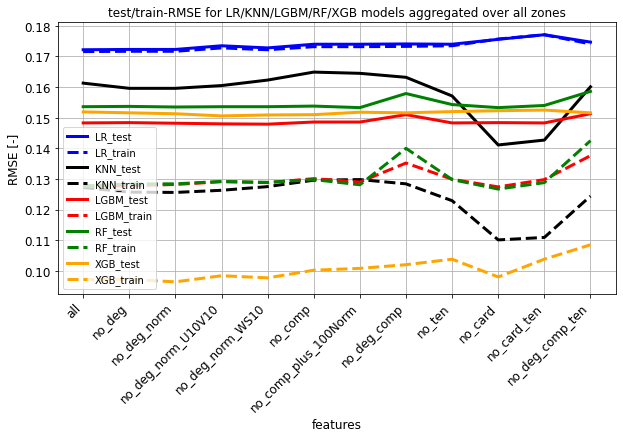

In [28]:
## plot RMSE for different models against various feature combinations
models = ['LR', 'KNN', 'LGBM', 'RF', 'XGB']
x = [key for key in feature_dict.keys()]
score = {}

colors = ['b','k','r','green','orange']
linestyles = ['-','--']
fontsize = 12
plt.figure(figsize=(10,5))

for i1,model in enumerate(models):
    for i2,tt in enumerate(['test','train']):
        score['{}_{}'.format(model,tt)] = [results[key]['{}_{}'.format(model,tt)]['TOTAL'] for key in feature_dict.keys()]
        plt.plot(x, score['{}_{}'.format(model,tt)], color=colors[i1], linestyle=linestyles[i2], linewidth=3)
plt.xticks(rotation=45, ha='right', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('RMSE [-]', fontsize = fontsize)
plt.xlabel('features', fontsize = fontsize)
plt.legend(['{}_{}'.format(model,tt) for model in models for tt in ['test','train']],loc='lower left')
plt.title(f"test/train-RMSE for {'/'.join(models)} models aggregated over all zones", fontsize = fontsize)
plt.grid()

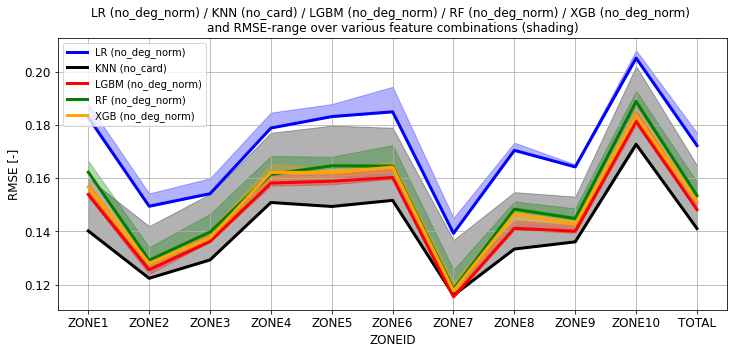

In [73]:
## plot test-RMSE for different models against various zones and give RMSE-range over different feature combinations
ranges = {model : np.ones((len(zones)+1,1)) * np.nan for model in models}
fontsize = 12

for model in models:
    for key in results.keys():
        ranges[model] = np.append(ranges[model], 
                                  np.array([value for value in results[key]['{}_test'.format(model)].values()]).reshape(-1,1), 
                                  axis=1)
    ranges[model] = (np.min(ranges[model][:,1:],axis=1), np.max(ranges[model][:,1:],axis=1))

x = list(results['no_deg_norm']['LR_test'].keys())
plt.figure(figsize=(12,5))
plt.plot(x, list(results['no_deg_norm']['LR_test'].values()), 'b', linewidth=3)
plt.plot(x, list(results['no_card']['KNN_test'].values()), 'k', linewidth=3)
plt.plot(x, list(results['no_deg_norm']['LGBM_test'].values()), 'r', linewidth=3)
plt.plot(x, list(results['no_deg_norm']['RF_test'].values()), 'green', linewidth=3)
plt.plot(x, list(results['no_deg_norm']['XGB_test'].values()), 'orange', linewidth=3)
plt.grid()
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel('RMSE [-]', fontsize=fontsize)
plt.xlabel('ZONEID', fontsize=fontsize)

colors = ['b','k','r','green','orange']
for i,model in enumerate(models):
    plt.fill_between(x, ranges[model][0], ranges[model][1], alpha=.3, color=colors[i])

plt.legend(['{} (no_card)'.format(model) if model == 'KNN' else '{} (no_deg_norm)'.format(model) for model in models])
plt.title('{} {}'.format(' / '.join(['{} (no_card)'.format(model) if model == 'KNN' else '{} (no_deg_norm)'.format(model) for model in models]),
                         '\nand RMSE-range over various feature combinations (shading)'));
